In [2]:
import numpy as np
import json

import sys
sys.path.insert(0, '../../../')

import ml

from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.callbacks import EarlyStopping
from keras import models, layers


import matplotlib.pyplot as plt


dtypes = ['train', 'validate', 'test']

2024-05-21 21:53:51.661342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/QPL/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Train CNNs on the simulated data

In this notebook, we train CNNs on the simulated datasets that were not used in the hyperparameter tuning process. For each dataset, we:
   - Create a CNN with the same model architecture as the optimal model found using the `experiment_0` dataset.
   - Train the CNN on the `experiment_{exp_id}` dataset.
   - Make predictions for the fidelity of all the circuits in the dataset.
   - Save the model, training history, and predictions.
   - Make predictions on the dataset's out-of-distribution set of mirror circuits.

# Set the notebook parameters

In [3]:
exp_num = 4

In [4]:
alphas = {'train': 1, 'validate': .75, 'test': .4}

exp_path = f'./experiment_{exp_num}/'
sim_path = exp_path + '/simulation_results/'
proc_path = exp_path + '/processed_inputs_and_outputs/'

model_path = exp_path + '/models/'
history_path = exp_path + '/training_histories/'
pred_path = exp_path + '/predictions/'

tuned_model_path = './experiment_0/models/tuned_cnn/'

# Load, process, and save the circuits

In [5]:
with open(exp_path+'/meta.json', 'r') as f:
    meta = json.load(f)

num_qubits = meta['num_qubits']
max_error_weight = meta['max_error_weight']
num_hops = meta['num_hops']
num_channels = meta['num_channels']
if meta['geometry'] == 'ring':
    adj_matrix = ml.newtools.ring_adj_matrix(num_qubits)
    laplace = ml.newtools.laplace_from_qubit_graph(adj_matrix)
else:
    print(f'You have not implemented the {geometry} geometry.')

len_encoding = num_qubits * num_channels

In [6]:
circuits = np.load(proc_path+'/processed_high_fidelity_circuits.npz')
infidelities = np.load(proc_path+'/processed_infidelities.npz')

x_circs = {dt: circuits[dt][:, :, :len_encoding] for dt in dtypes}

x_c_t = {dt: np.transpose(x_circs[dt], axes = (0, 2, 1)) for dt in dtypes}
x_c_t_r = {dt: x_c_t[dt].reshape(x_c_t[dt].shape[0], num_qubits, num_channels, -1) for dt in dtypes}

cnn_circs = {dt: np.transpose(x_c_t_r[dt], axes = (0, 1, 3, 2)) for dt in dtypes}
cnn_fids = {dt: infidelities[dt] for dt in dtypes}

input_shape = cnn_circs['train'][0].shape

In [6]:
np.savez_compressed(proc_path + 'processed_cnn_high_fidelity_circuits.npz', **cnn_circs)

# Create the model

In [7]:
og_model = models.load_model(tuned_model_path)

In [8]:
new_model = models.clone_model(og_model)
optimizer = Adam(learning_rate=1e-3)
new_model.compile(optimizer, MeanSquaredError())

In [9]:
callback = EarlyStopping(monitor='val_loss', patience=10, min_delta = 50)

history1 = new_model.fit(cnn_circs['train'], cnn_fids['train'], epochs=60, batch_size=32, 
                             validation_data=[cnn_circs['validate'], cnn_fids['validate']], callbacks = [callback])

Epoch 1/60
88/88 [==============================] - 2s 14ms/step - loss: 20199.7480 - val_loss: 9803.8457
Epoch 2/60
88/88 [==============================] - 1s 12ms/step - loss: 7996.9482 - val_loss: 8268.9121
Epoch 3/60
88/88 [==============================] - 1s 12ms/step - loss: 6936.1255 - val_loss: 7540.8608
Epoch 4/60
88/88 [==============================] - 1s 13ms/step - loss: 6364.0063 - val_loss: 7286.9189
Epoch 5/60
88/88 [==============================] - 1s 12ms/step - loss: 6103.7529 - val_loss: 6993.2158
Epoch 6/60
88/88 [==============================] - 1s 13ms/step - loss: 6009.7954 - val_loss: 6868.2681
Epoch 7/60
88/88 [==============================] - 1s 13ms/step - loss: 5849.7134 - val_loss: 6996.7129
Epoch 8/60
88/88 [==============================] - 1s 12ms/step - loss: 5881.8813 - val_loss: 7114.0234
Epoch 9/60
88/88 [==============================] - 1s 12ms/step - loss: 5804.8403 - val_loss: 6747.9116
Epoch 10/60
88/88 [==============================] - 1

In [10]:
predictions = {dtype: new_model.predict(cnn_circs[dtype]).reshape((-1,)) for dtype in ['train', 'validate', 'test']}
abs_errors = {dt: np.abs(predictions[dt]/100-cnn_fids[dt]/100) for dt in dtypes}

39/39 [==============================] - 0s 4ms/step


In [11]:
np.savez_compressed(pred_path + 'processed_cnn_predictions.npz', **predictions)

new_model.save(model_path+'/tuned_cnn/')

with open(history_path + 'cnn-history.json', 'w') as file:
    json.dump(history1.history, file)

2024-05-21 10:09:12.201844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10]
	 [[{{node inputs}}]]
2024-05-21 10:09:12.472167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,10]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: ./experiment_4//models//tuned_cnn/assets


INFO:tensorflow:Assets written to: ./experiment_4//models//tuned_cnn/assets


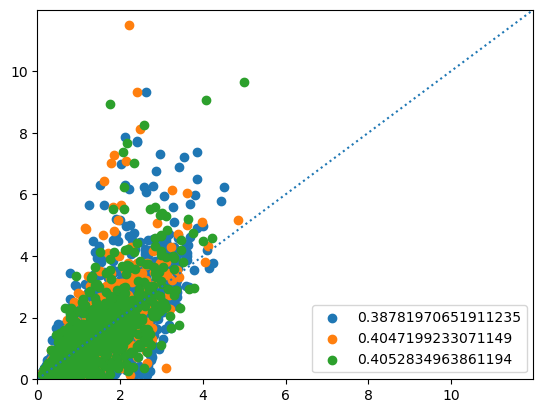

In [12]:
for dt in dtypes:
    plt.scatter(predictions[dt] / 100, cnn_fids[dt] / 100, label=np.mean(abs_errors[dt]))

max_infidelity = np.max([np.max(cnn_fids[dt] / 100) for dt in dtypes])
max_pred = np.max([np.max(predictions[dt] / 100) for dt in dtypes])
max_val = max(max_infidelity, max_pred)
                        
plt.plot([0,max_val+.5],[0,max_val+.5], ':')
plt.xlim(0,max_val+.5)
plt.ylim(0,max_val+.5)
plt.legend()

In [1]:
cnn_fids['test']

NameError: name 'cnn_fids' is not defined

# Mirror circuits

In [13]:
from keras.models import load_model

alphas = {'train': 1, 'validate': .75, 'test': .4}

exp_path = f'./experiment_{exp_num}/'
sim_path = exp_path + '/simulation_results/'
proc_path = exp_path + '/processed_inputs_and_outputs/'

model_path = exp_path + '/models/'
history_path = exp_path + '/training_histories/'
pred_path = exp_path + '/predictions/'

with open(exp_path+'/meta.json', 'r') as f:
    meta = json.load(f)

num_qubits = meta['num_qubits']
num_channels = meta['num_channels']

In [14]:
o_circuits = np.load(proc_path + '/processed_mirrored_circuits.npz')['circuits']
o_infidelities = np.load(proc_path + '/processed_mirrored_infidelities.npz')['infidelities']

o_circuits = o_circuits[:, :, :len_encoding]

o_c_t = np.transpose(o_circuits, axes = (0, 2, 1))
o_c_t_r = o_c_t.reshape(o_c_t.shape[0], num_qubits, num_channels, -1)
mirrored_cnn_circuits = np.transpose(o_c_t_r, axes = (0, 1, 3, 2))

In [15]:
np.savez_compressed(proc_path + '/processed_cnn_mirrored_circuits.npz', circuits = mirrored_cnn_circuits)

In [16]:
cnn1 = load_model(model_path + '/tuned_cnn/')

In [17]:
mirrored_preds = cnn1.predict(mirrored_cnn_circuits).reshape((len(o_circuits),))
mirrored_abs_errors = np.abs(mirrored_preds / 100 - o_infidelities / 100)

24/24 [==============================] - 0s 5ms/step


In [18]:
np.savez_compressed(pred_path + '/processed_cnn_mirrored_predictions.npz', predictions = mirrored_preds)

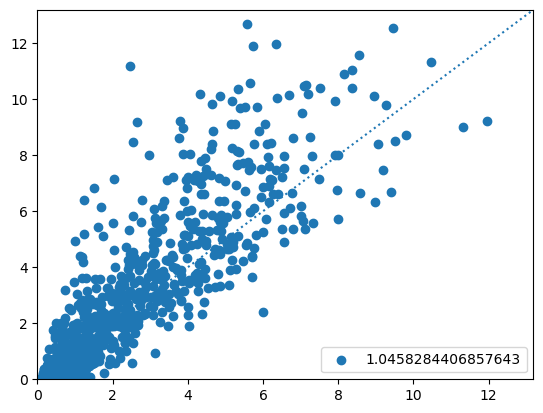

In [19]:
plt.scatter(mirrored_preds / 100, o_infidelities / 100, label=np.mean(mirrored_abs_errors))

max_infidelity = np.max(o_infidelities / 100)
max_pred = np.max(mirrored_preds / 100)
max_val = max(max_infidelity, max_pred)
                        
plt.plot([0,max_val+.5],[0,max_val+.5], ':')
plt.xlim(0,max_val+.5)
plt.ylim(0,max_val+.5)
plt.legend()